# Τεχνικές Eξόρυξης Δεδομένων - Άσκηση 2
_Βαργιάμης Μιχαήλ, sdi1300018_

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords')
import copy
import re
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction import text
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

C:\Users\Mike\anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
dftrue = pd.read_csv("True.csv")
dffake = pd.read_csv("Fake.csv")

## Προεπεξεργασία - καθάρισμα

In [3]:
dftrue = dftrue.head(1000)
dffake = dffake.head(1000)

In [4]:
from nltk.corpus import stopwords

def str_lower(df, columns):
    for col in columns:
        df[col] = df[col].str.lower()
    return df

def remove_punctuation(df, columns):
    for col in columns:
        df[col] = df[col].str.replace(r'[^\w\s]+', '')
    return df

def remove_stopwords(df, columns):
    stop = stopwords.words('english')
    for col in columns:
        df[col] = df[col].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return df

In [5]:
# A list of contractions from http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
contractions = { 
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he would",
"he'd've": "he would have",
"he'll": "he will",
"he's": "he is",
"how'd": "how did",
"how'll": "how will",
"how's": "how is",
"i'd": "i would",
"i'll": "i will",
"i'm": "i am",
"i've": "i have",
"isn't": "is not",
"it'd": "it would",
"it'll": "it will",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"must've": "must have",
"mustn't": "must not",
"needn't": "need not",
"oughtn't": "ought not",
"shan't": "shall not",
"sha'n't": "shall not",
"she'd": "she would",
"she'll": "she will",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"that'd": "that would",
"that's": "that is",
"there'd": "there had",
"there's": "there is",
"they'd": "they would",
"they'll": "they will",
"they're": "they are",
"they've": "they have",
"wasn't": "was not",
"we'd": "we would",
"we'll": "we will",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"where'd": "where did",
"where's": "where is",
"who'll": "who will",
"who's": "who is",
"won't": "will not",
"wouldn't": "would not",
"you'd": "you would",
"you'll": "you will",
"you're": "you are"
}

In [6]:
def clean_text(text, remove_stopwords = True):
    '''Remove unwanted characters, stopwords, and format the text to create fewer nulls word embeddings'''
    
    # Convert words to lower case
    text = text.lower()
    
    # Replace contractions with their longer forms 
    if True:
        text = text.split()
        new_text = []
        for word in text:
            if word in contractions:
                new_text.append(contractions[word])
            else:
                new_text.append(word)
        text = " ".join(new_text)
    
    # Format words and remove unwanted characters
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'\<a href', ' ', text)
    text = re.sub(r'&amp;', '', text) 
    text = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', '', text)
    text = re.sub(r'<br />', ' ', text)
    text = re.sub(r'\'', ' ', text)
    
    # remove stop words
    if remove_stopwords:
        text = text.split()
        stops = set(stopwords.words("english"))
        text = [w for w in text if not w in stops]
        text = " ".join(text)

    # Tokenize each word
    text =  nltk.WordPunctTokenizer().tokenize(text)
        
    return text

## Μελέτη των δεδομένων

#### α) και β)

In [7]:
def avg_char_count(df, column):
    return sum([ sum([1 for c in s if c.isalpha() or c.isdigit() ]) for s in df[column] ])/ len(df)

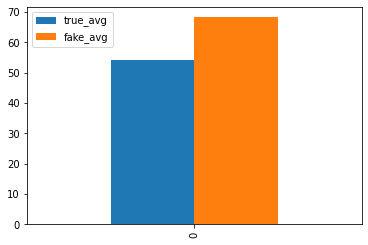

In [8]:
pd.DataFrame({
    "true_avg": [avg_char_count(dftrue, "title")],
    "fake_avg": [avg_char_count(dffake, "title")],
}).plot.bar()
None

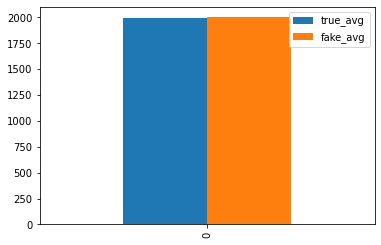

In [9]:
pd.DataFrame({
    "true_avg": [avg_char_count(dftrue, "text")],
    "fake_avg": [avg_char_count(dffake, "text")],
}).plot.bar()
None

#### γ) και δ)

In [10]:
from collections import Counter

def plot_word_count(df, col):
    count = [len(s) for s in df[col]]
    dftemp = pd.DataFrame({
        "count": count
    })
    dftemp.hist(bins=20, column='count')

In [11]:
dftruestop = copy.deepcopy(dftrue)
dffakestop = copy.deepcopy(dffake)
dftruestop = remove_stopwords(dftruestop, ["title", "text"])
dffakestop = remove_stopwords(dffakestop, ["title", "text"])

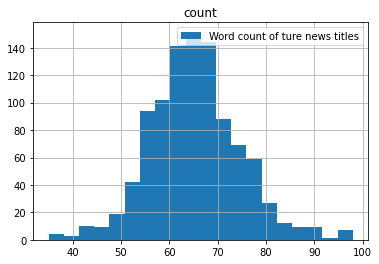

In [12]:
plot_word_count(dftrue, 'title')
plt.legend(["Word count of ture news titles"])
None

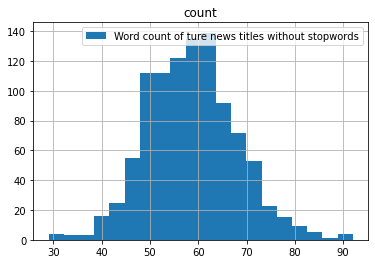

In [13]:
plot_word_count(dftruestop, 'title')
plt.legend(["Word count of ture news titles without stopwords"])
None

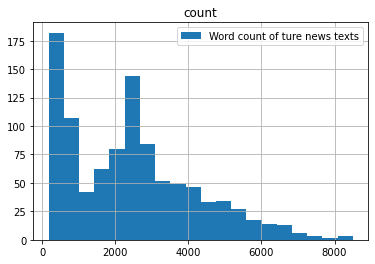

In [14]:
plot_word_count(dftrue, 'text')
plt.legend(["Word count of ture news texts"])
None

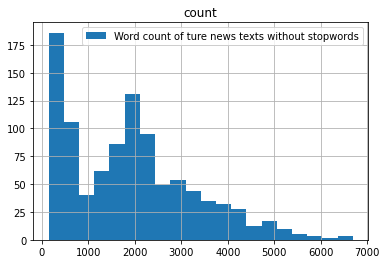

In [15]:
plot_word_count(dftruestop, 'text')
plt.legend(["Word count of ture news texts without stopwords"])
None

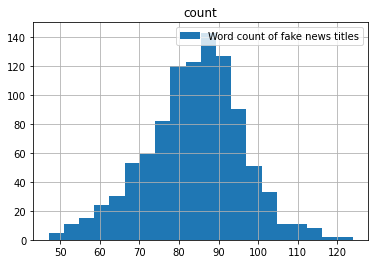

In [16]:
plot_word_count(dffake, 'title')
plt.legend(["Word count of fake news titles"])
None

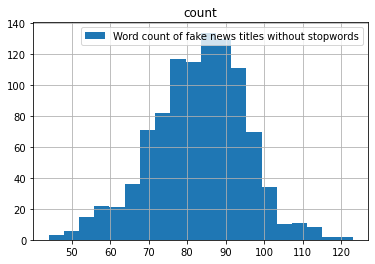

In [17]:
plot_word_count(dffakestop, 'title')
plt.legend(["Word count of fake news titles without stopwords"])
None

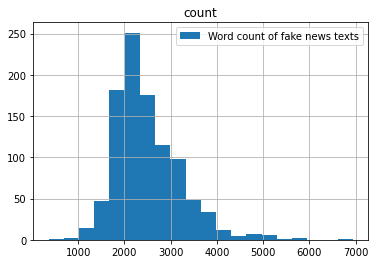

In [18]:
plot_word_count(dffake, 'text')
plt.legend(["Word count of fake news texts"])
None

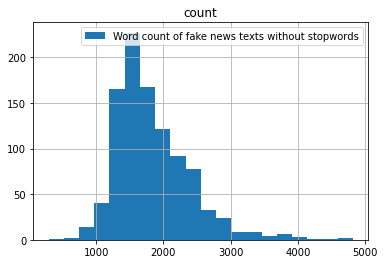

In [19]:
plot_word_count(dffakestop, 'text')
plt.legend(["Word count of fake news texts without stopwords"])
None

## Δημιουργία συνόλου εκμάθησης και δοκιμής

In [20]:
# Combine title text and subject in one column
dftrue['text_combined'] = dftrue.title + " " + dftrue.text + " " + dftrue.subject
dffake['text_combined'] = dffake.title + " " + dffake.text + " " + dffake.subject

In [21]:
# Preprocess text of new combined column
dftrue['text_cleaned'] = list(map(clean_text, dftrue.text_combined))
dftrue = dftrue.drop(['text_combined'], axis=1)
dffake['text_cleaned'] = list(map(clean_text, dffake.text_combined))
dffake = dffake.drop(['text_combined'], axis=1)

In [22]:
# Define split size
size = len(dftrue)
splitsize = int(0.5 * len(dftrue))

# Split dftrue to train and test
dftraintrue = dftrue.head(splitsize)
dftesttrue = dftrue.tail(size - splitsize)

# Add labels
dftraintrue.insert(4, "label", [1 for i in range(splitsize)])
dftesttrue.insert(4, "label", [1 for i in range(size - splitsize)])

# Split dffake to train and test
dftrainfake = dffake.head(size - splitsize)
dftestfake = dffake.tail(splitsize)

# Add labels
dftrainfake.insert(4, "label", [0 for i in range(size - splitsize)])
dftestfake.insert(4, "label", [0 for i in range(splitsize)])

# Merge into dftrain and dftest respectively
dftrain = dftraintrue.append(dftrainfake, ignore_index=True)
dftest = dftesttrue.append(dftestfake, ignore_index=True)

# Write to csv
dftrain.to_csv("Train.csv")
dftest.to_csv("Test.csv")

## Classification

In [23]:
# Bag of Words Transofrmation

bow_transform = CountVectorizer(tokenizer=lambda doc: doc, ngram_range=[3,3], lowercase=False)
x_train_bow = bow_transform.fit_transform(dftrain['text_cleaned'])
x_test_bow = bow_transform.transform(dftest['text_cleaned'])

In [24]:
# Labels

y_train = dftrain['label']
y_test = dftest['label']

In [25]:
# TF-IDF Transformation

tfidf_transform = text.TfidfTransformer()
x_train_tfidf = tfidf_transform.fit_transform(x_train_bow)
x_test_tfidf = tfidf_transform.transform(x_test_bow)

In [26]:
# Word2Vec Transformation

# Combine vocabulary from dftrain and dftest
dfcomb = dftrain['text_cleaned'].append(dftest['text_cleaned'], ignore_index=True).to_frame()
w2v = Word2Vec(dfcomb['text_cleaned'],
                vector_size=100,
                seed=32,
                negative=5,
                sg=0,
                min_count=1,
                window=1)
w2v.build_vocab(dfcomb['text_cleaned'])
w2v.train(dfcomb['text_cleaned'], total_examples=w2v.corpus_count, epochs=5)

# Compute the mean for each word
transformed_vocabulary = {
    word: w2v.wv[word].mean(axis=0)
for word in w2v.wv.index_to_key
}

# Create 2d array for training
x_train_w2v = [
    [
        transformed_vocabulary[word] for word in text ]
    for text in dftrain['text_cleaned'] ]

# Create 2d array for testing
x_test_w2v = [
    [
        transformed_vocabulary[word]
    for word in text ] 
for text in dftest['text_cleaned'] ]

# Pad arrays with zeroes so that they have the same dimensions
maxlen1 = len(max(x_train_w2v, key=len))
maxlen2 = len(max(x_test_w2v, key=len))
maxlen = max(maxlen1, maxlen2)
x_train_w2v = [np.pad(row, (0, maxlen - len(row)), 'constant') for row in x_train_w2v]
x_test_w2v = [np.pad(row, (0, maxlen - len(row)), 'constant') for row in x_test_w2v]

### Logistic Regression

In [27]:
lr = LogisticRegression()
lr.fit(x_train_bow, y_train)
score = lr.score(x_test_bow, y_test)
print('%-50s %.4f' % ('Logistic Regression BoW Accuracy score:', score))
print('%-50s %.4f' % ('Logistic Regression BoW F1 score:', f1_score(y_test, lr.predict(x_test_bow))))

Logistic Regression BoW Accuracy score:            0.9320
Logistic Regression BoW F1 score:                  0.9286


In [28]:
lr = LogisticRegression()
lr.fit(x_train_tfidf, y_train)
score = lr.score(x_test_tfidf, y_test)
print('%-50s %.4f' % ('Logistic Regression TF-IDF Accuracy score:', score))
print('%-50s %.4f' % ('Logistic Regression TF-IDF F1 score:', f1_score(y_test, lr.predict(x_test_tfidf))))

Logistic Regression TF-IDF Accuracy score:         0.9360
Logistic Regression TF-IDF F1 score:               0.9382


In [29]:
lr = LogisticRegression()
lr.fit(x_train_w2v, y_train)
score = lr.score(x_test_w2v, y_test)
print('%-50s %.4f' % ('Logistic Regression W2V Accuracy score:', score))
print('%-50s %.4f' % ('Logistic Regression W2V F1 score:', f1_score(y_test, lr.predict(x_test_w2v))))

Logistic Regression W2V Accuracy score:            0.7110
Logistic Regression W2V F1 score:                  0.6778


### Naive Bayes

In [30]:
gnb = GaussianNB()
gnb.fit(x_train_bow.toarray(), y_train)
y_pred_bow = gnb.predict(x_test_bow.toarray())
score = metrics.accuracy_score(y_test, y_pred_bow)
print('%-50s %.4f' % ('Naive Bayes BoW Accuracy score:', score))
print('%-50s %.4f' % ('Naive Bayes BoW F1 score:', f1_score(y_test, y_pred_bow)))

Naive Bayes BoW Accuracy score:                    0.9580
Naive Bayes BoW F1 score:                          0.9592


In [31]:
gnb = GaussianNB()
gnb.fit(x_train_tfidf.toarray(), y_train)
y_pred_tfidf = gnb.predict(x_test_tfidf.toarray())
score = metrics.accuracy_score(y_test, y_pred_tfidf)
print('%-50s %.4f' % ('Naive Bayes TF-IDF Accuracy score:', score))
print('%-50s %.4f' % ('Naive Bayes TF-IDF F1 score:', f1_score(y_test, y_pred_tfidf)))

Naive Bayes TF-IDF Accuracy score:                 0.9350
Naive Bayes TF-IDF F1 score:                       0.9378


In [32]:
gnb = GaussianNB()
gnb.fit(x_train_w2v, y_train)
y_pred_w2v = gnb.predict(x_test_w2v)
score = metrics.accuracy_score(y_test, y_pred_w2v)
print('%-50s %.4f' % ('Naive Bayes W2V Accuracy score:', score))
print('%-50s %.4f' % ('Naive Bayes W2V F1 score:', f1_score(y_test, y_pred_w2v)))

Naive Bayes W2V Accuracy score:                    0.6120
Naive Bayes W2V F1 score:                          0.3918


### Support Vector Machines

In [33]:
from sklearn.metrics import classification_report
svc = SVC()
svc.fit(x_train_bow, y_train)
predictions = svc.predict(x_test_bow)
print("Support Vector Machines BoW\n")
print(classification_report(y_test, predictions))

Support Vector Machines BoW

              precision    recall  f1-score   support

           0       0.85      0.98      0.91       500
           1       0.97      0.82      0.89       500

    accuracy                           0.90      1000
   macro avg       0.91      0.90      0.90      1000
weighted avg       0.91      0.90      0.90      1000



In [34]:
svc = SVC()
svc.fit(x_train_tfidf, y_train)
predictions = svc.predict(x_test_tfidf)
print("Support Vector Machines TF-IDF\n")
print(classification_report(y_test, predictions))

Support Vector Machines TF-IDF

              precision    recall  f1-score   support

           0       0.96      0.93      0.94       500
           1       0.93      0.96      0.94       500

    accuracy                           0.94      1000
   macro avg       0.94      0.94      0.94      1000
weighted avg       0.94      0.94      0.94      1000



In [35]:
svc = SVC()
svc.fit(x_train_w2v, y_train)
predictions = svc.predict(x_test_w2v)
print("Support Vector Machines W2V\n")
print(classification_report(y_test, predictions))

Support Vector Machines W2V

              precision    recall  f1-score   support

           0       0.76      0.81      0.78       500
           1       0.80      0.74      0.77       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



In [36]:
# Re run using GridsearchCV

# Define parameter range
param_grid = {'C': [0.1, 1, 10, 100], 
              'gamma': [1, 0.1, 0.01, 0.001],
              'kernel': ['rbf', 'linear']} 
# Create grid
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)

In [37]:
# Train again for BoW
#grid.fit(x_train_bow, y_train)
#print(grid.best_params_)
#grid_predictions = grid.predict(x_test_bow)
#print(classification_report(y_test, grid_predictions))

In [38]:
# Train again for TF-IDF
#grid.fit(x_train_tfidf, y_train)
#print(grid.best_params_)
#grid_predictions = grid.predict(x_test_tfidf)
#print(classification_report(y_test, grid_predictions))

In [39]:
# Train again for W2V
#grid.fit(x_train_w2v, y_train)
#print(grid.best_params_)
#grid_predictions = grid.predict(x_test_w2v)
#print(classification_report(y_test, grid_predictions))

### Random Forests

In [40]:
rfc = RandomForestClassifier()
rfc.fit(x_train_bow, y_train)
predictions = rfc.predict(x_test_bow)
print("Random Forests BoW\n")
print(classification_report(y_test, predictions))

Random Forests BoW

              precision    recall  f1-score   support

           0       0.80      1.00      0.89       500
           1       1.00      0.75      0.86       500

    accuracy                           0.88      1000
   macro avg       0.90      0.88      0.87      1000
weighted avg       0.90      0.88      0.87      1000



In [41]:
rfc = RandomForestClassifier()
rfc.fit(x_train_tfidf, y_train)
predictions = rfc.predict(x_test_tfidf)
print("Random Forests TF-IDF\n")
print(classification_report(y_test, predictions))

Random Forests TF-IDF

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       500
           1       1.00      0.80      0.89       500

    accuracy                           0.90      1000
   macro avg       0.92      0.90      0.90      1000
weighted avg       0.92      0.90      0.90      1000



In [42]:
rfc = RandomForestClassifier()
rfc.fit(x_train_w2v, y_train)
predictions = rfc.predict(x_test_w2v)
print("Random Forests W2V\n")
print(classification_report(y_test, predictions))

Random Forests W2V

              precision    recall  f1-score   support

           0       0.82      0.89      0.86       500
           1       0.88      0.81      0.84       500

    accuracy                           0.85      1000
   macro avg       0.85      0.85      0.85      1000
weighted avg       0.85      0.85      0.85      1000

